In [1]:
%%time
import numpy as np
import scanpy as sc
import os
import pandas as pd
import bbknn

sc.settings.verbosity = 4                
sc.settings.set_figure_params(80)                 
sc.settings.file_format_figures = 'png'  
sc.settings.savefigs = False            
use_first_n_samples = 0
full_sparse = False


Wall time: 16 s


# Batch 

In [2]:
def processing_batch(adata,neighbors = 15,key='Sample',reso=0.4): # Higher resolution yields more leiden clusters 
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.logging.print_memory_usage()
    sc.pp.neighbors(adata, n_neighbors=neighbors)
    sc.pl.pca_variance_ratio(adata, log=True)
    bbknn.bbknn(adata, batch_key=key, neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=reso)
    sc.pl.umap(adata,color='leiden')

In [3]:
adata = sc.read(r"C:\Users\TzachiHNB5\Desktop\presentations\gut_characterization\gut_bat1k_raw.h5ad") #adata after QC
# if the anndata object is processed and contains the raw data in adata.raw run -  adata = adata.raw.to_adata()

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    Gene indices [17913, 25526] fell into a single bin: their normalized dispersion was set to 1.
    Decreasing `n_bins` will likely avoid this effect.
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


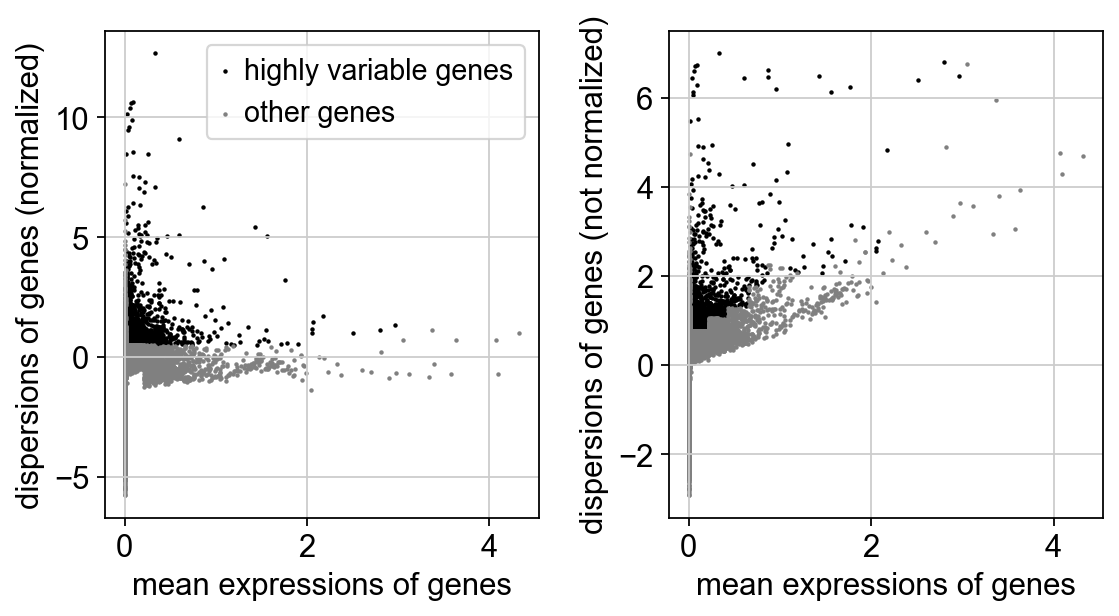

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
adata = adata[:, adata.var.highly_variable] # For filtering non Highly variable genes. We usually keep all the genes. 

In [5]:
sc.pp.regress_out(adata, ['total_counts','pct_counts_MT']) 

regressing out ['total_counts', 'pct_counts_MT']
    sparse input is densified and may lead to high memory use
    finished (0:01:02)


    ... clipping at max_value 10
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:05)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
Memory usage: current 3.08 GB, difference +3.08 GB
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 50
    computed neighbors (0:00:11)
    computed connectivities (0:00:02)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


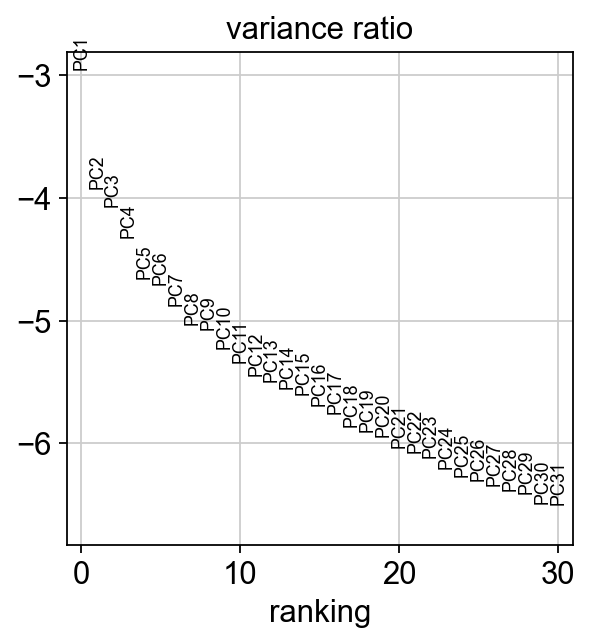

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)


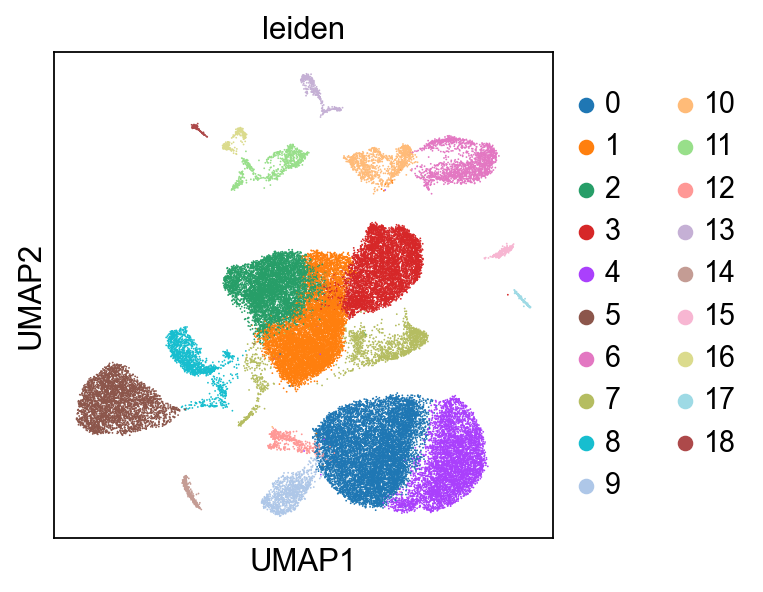

In [6]:
processing_batch(adata) # Starting with a low resolution of leiden clustering

# Rank genes - DE analysis

ranking genes
    consider 'leiden' groups:
    with sizes: [9018 8794 5529 5437 4970 3446 1625 1579 1412 1007  996  681  403  364
  336  234  216  163  106]
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:24)


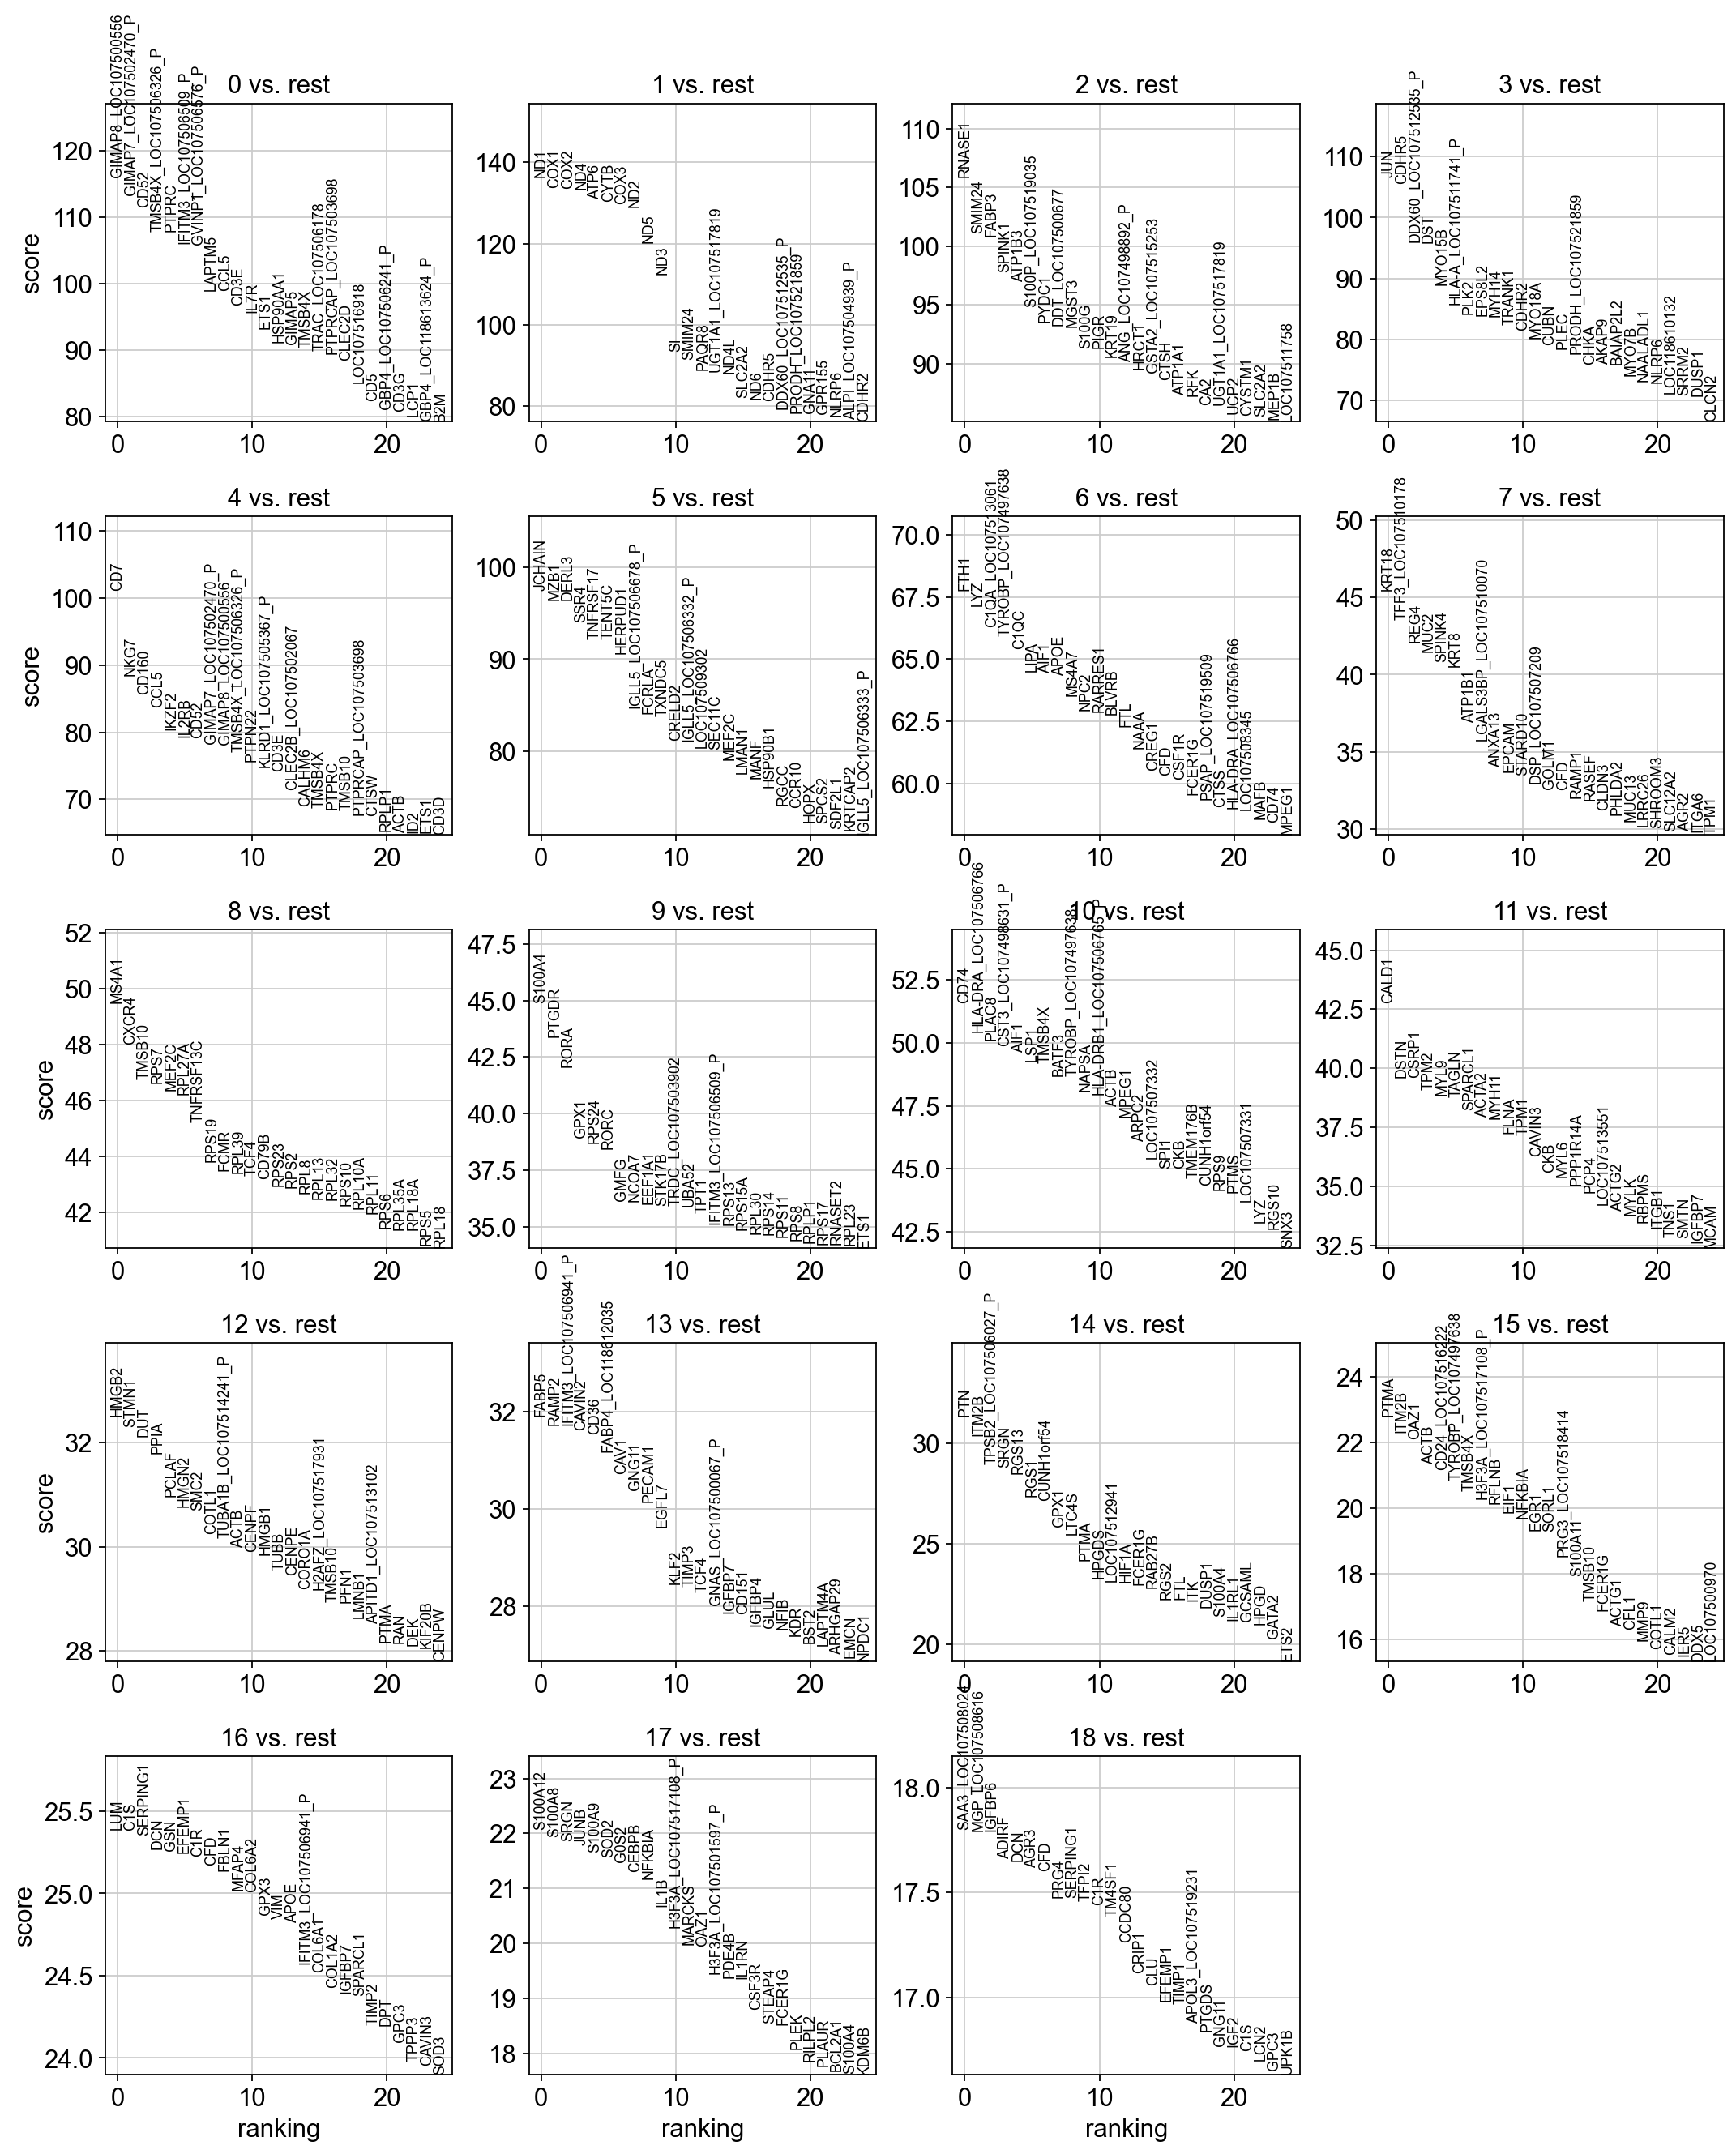

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,GIMAP8_LOC107500556,ND1,RNASE1,JUN,CD7,JCHAIN,FTH1,KRT18,MS4A1,S100A4,CD74,CALD1,HMGB2,FABP5,PTN,PTMA,LUM,S100A12,SAA3_LOC107508024
1,GIMAP7_LOC107502470_P,COX1,SMIM24,CDHR5,NKG7,MZB1,LYZ,TFF3_LOC107510178,CXCR4,PTGDR,HLA-DRA_LOC107506766,DSTN,STMN1,RAMP2,ITM2B,ITM2B,C1S,S100A8,MGP_LOC107508616
2,CD52,COX2,FABP3,DDX60_LOC107512535_P,CD160,DERL3,C1QA_LOC107513061,REG4,TMSB10,RORA,PLAC8,CSRP1,DUT,IFITM3_LOC107506941_P,TPSB2_LOC107506027_P,OAZ1,SERPING1,SRGN,IGFBP6
3,TMSB4X_LOC107506326_P,ND4,SPINK1,DST,CCL5,SSR4,TYROBP_LOC107497638,MUC2,RPS7,GPX1,CST3_LOC107498631_P,TPM2,PPIA,CAVIN2,SRGN,ACTB,DCN,JUNB,ADIRF
4,PTPRC,ATP6,ATP1B3,MYO15B,IKZF2,TNFRSF17,C1QC,SPINK4,MEF2C,RPS24,AIF1,MYL9,PCLAF,CD36,RGS13,CD24_LOC107516222,GSN,S100A9,DCN
5,IFITM3_LOC107506509_P,CYTB,S100P_LOC107519035,HLA-A_LOC107511741_P,IL2RB,TENT5C,LIPA,KRT8,RPL27A,RORC,LSP1,TAGLN,HMGN2,FABP4_LOC118612035,RGS1,TYROBP_LOC107497638,EFEMP1,SOD2,AGR3
6,GVINP1_LOC107506576_P,COX3,PYDC1,PLK2,CD52,HERPUD1,AIF1,ATP1B1,TNFRSF13C,GMFG,TMSB4X,SPARCL1,SMC2,CAV1,CUNH1orf54,TMSB4X,C1R,G0S2,CFD
7,LAPTM5,ND2,DDT_LOC107500677,EPS8L2,GIMAP7_LOC107502470_P,IGLL5_LOC107506678_P,APOE,LGALS3BP_LOC107510070,RPS19,NCOA7,BATF3,ACTA2,COTL1,GNG11,GPX1,H3F3A_LOC107517108_P,CFD,CEBPB,PRG4
8,CCL5,ND5,MGST3,MYH14,GIMAP8_LOC107500556,FCRLA,MS4A7,ANXA13,FCMR,EEF1A1,TYROBP_LOC107497638,MYH11,TUBA1B_LOC107514241_P,PECAM1,LTC4S,RFLNB,FBLN1,NFKBIA,SERPING1
9,CD3E,ND3,S100G,TRANK1,TMSB4X_LOC107506326_P,TXNDC5,NPC2,EPCAM,RPL39,STK17B,NAPSA,FLNA,ACTB,EGFL7,PTMA,EIF1,MFAP4,IL1B,TFPI2


In [7]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # Can also be 'cell_type' once annotated
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.set_option("display.max_columns", None)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

>Clusters 11, 16 and 18 express mesenchymal markers - TAGLN, DCN ,etc.. - further subclustering needed 

In [8]:
adata.obs['category'] = adata.obs.leiden.map({'11':'Mesenchymal','16':'Mesenchymal','18':'Mesenchymal'}).astype('category')

# Sub-clustering example

In [9]:
stromal = adata[adata.obs.category=='Mesenchymal']

computing batch balanced neighbors


c:\users\tzachihnb5\appdata\local\programs\python\python39\lib\site-packages\anndata\compat\_overloaded_dict.py:179: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ovld.data[key] = neighbors


	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


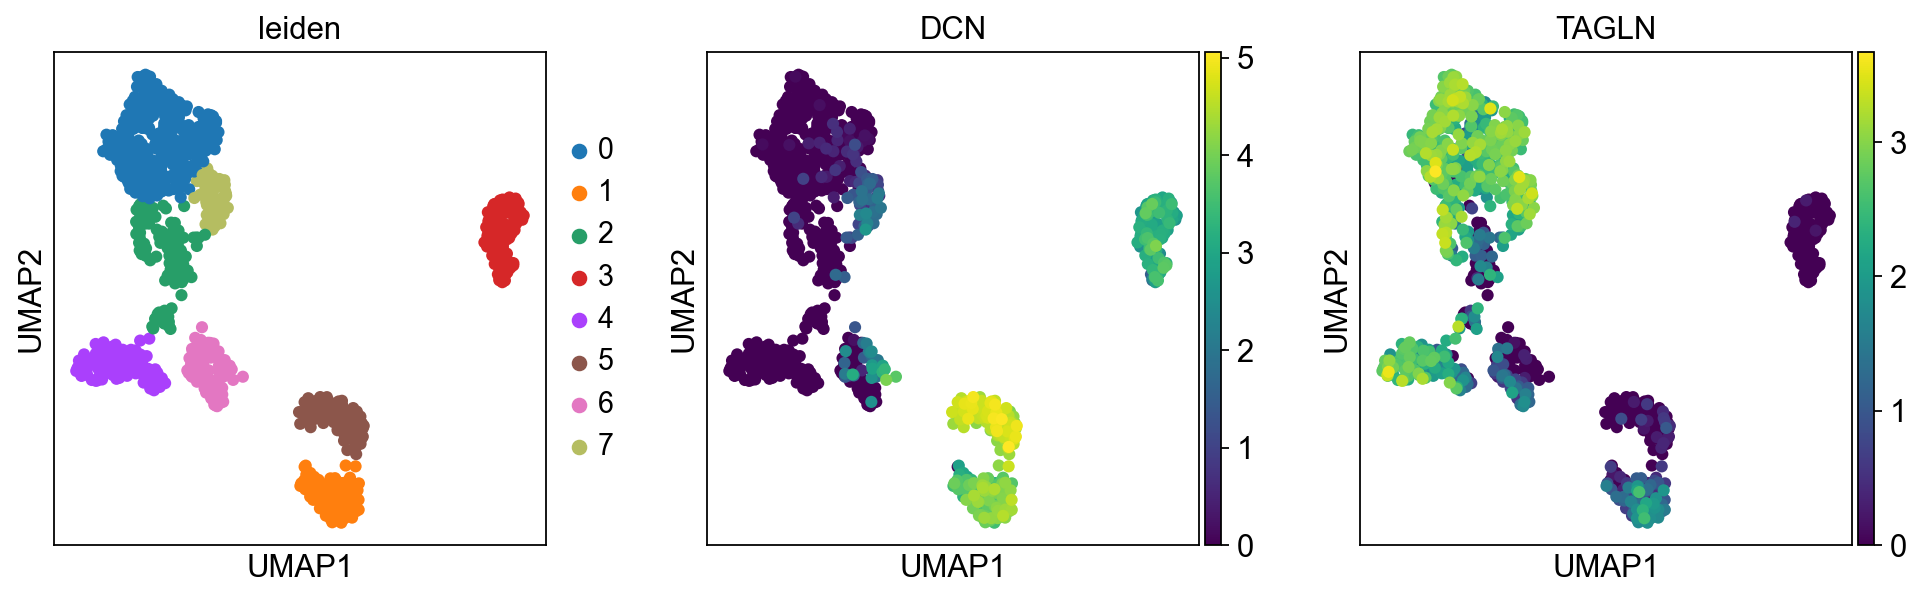

In [10]:
bbknn.bbknn(stromal, batch_key='Sample', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(stromal)
sc.tl.leiden(stromal, resolution=0.4)
sc.pl.umap(stromal,color =['leiden','DCN','TAGLN',])

> In order to find more specific cell types known markers from  Elmentaite, R. et al. Cells of the human intestinal tract mapped across space and time. Nature 597, (2021) will be checked for expression in the sub clusters

In [11]:
Fibroblasts = ['LUM','DCN','PDGFRA']
Fibroblast_types = ['ADAMDEC1','PI16']
Pericytes = ['NOTCH3','PDGFRB'] 
Smcs_and_myofibroblast = ['ACTA2','TAGLN','DES']
Glia = [ 'MPZ', 'CDH19', 'PLP1']
Mesothelium= ['LRRN4','PRG4']

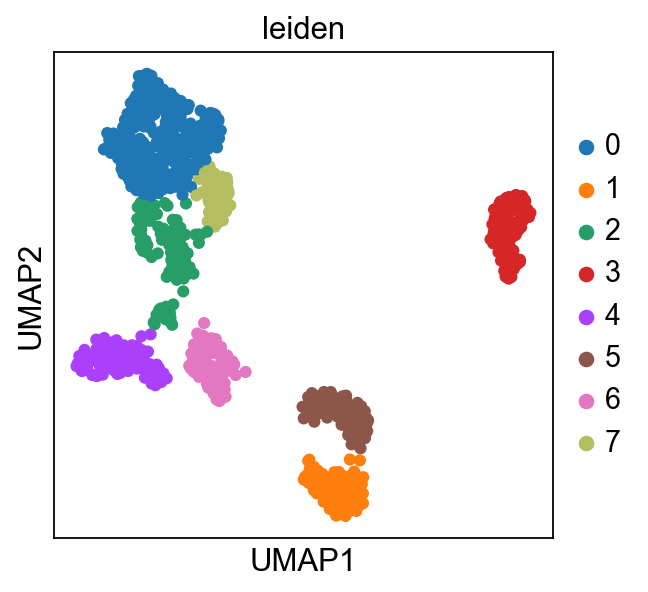

Fibroblasts


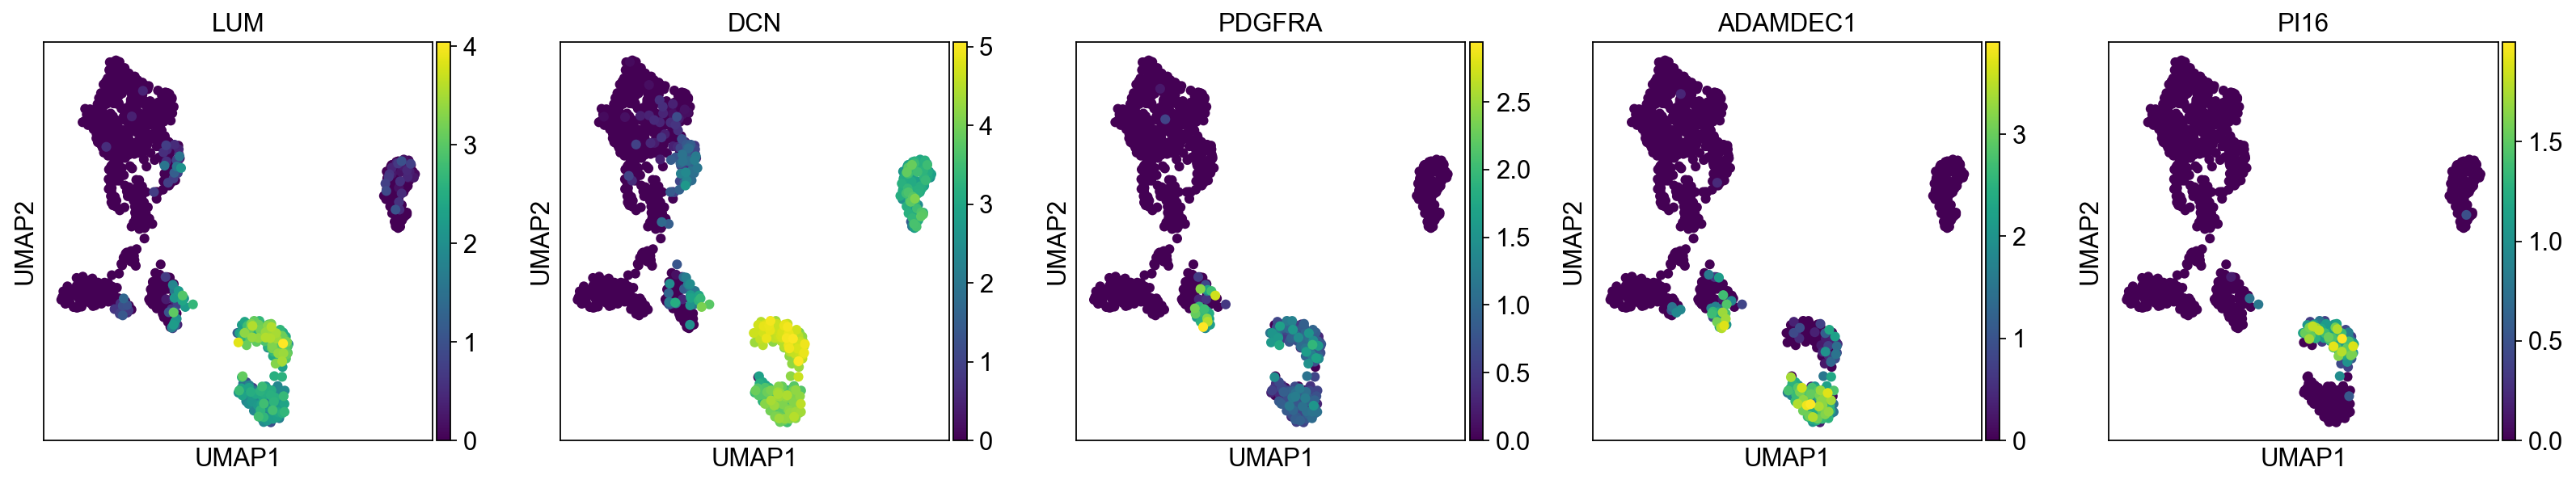

Pericytes


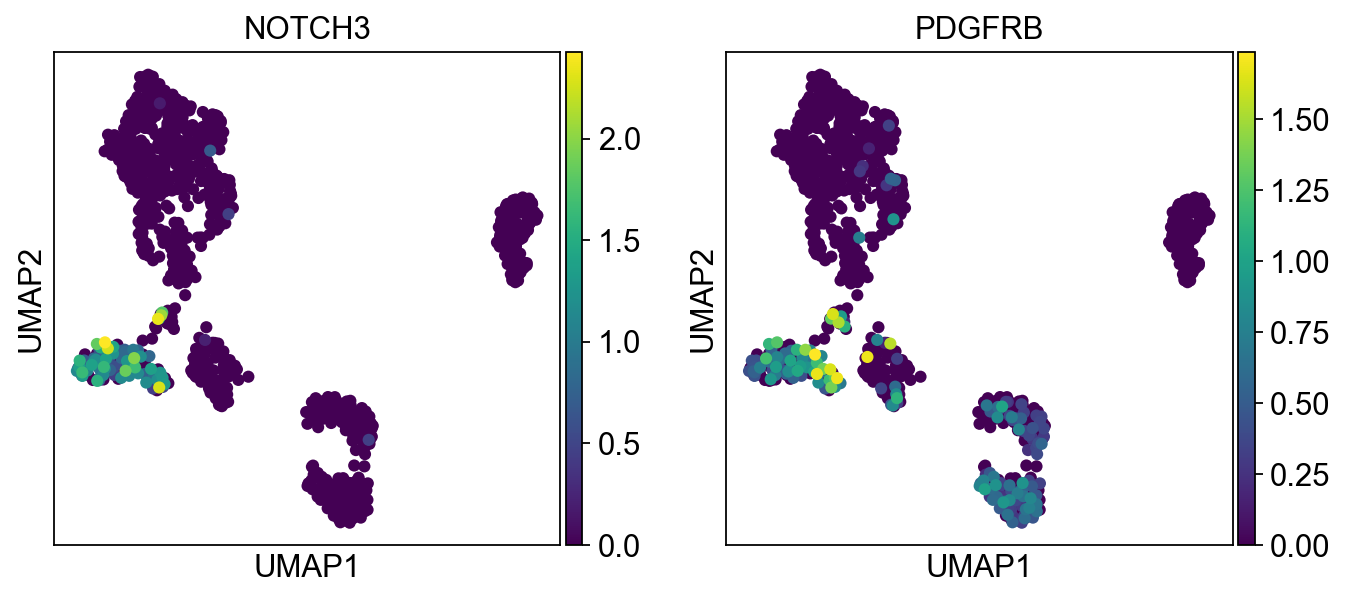

Smcs and myofibroblast


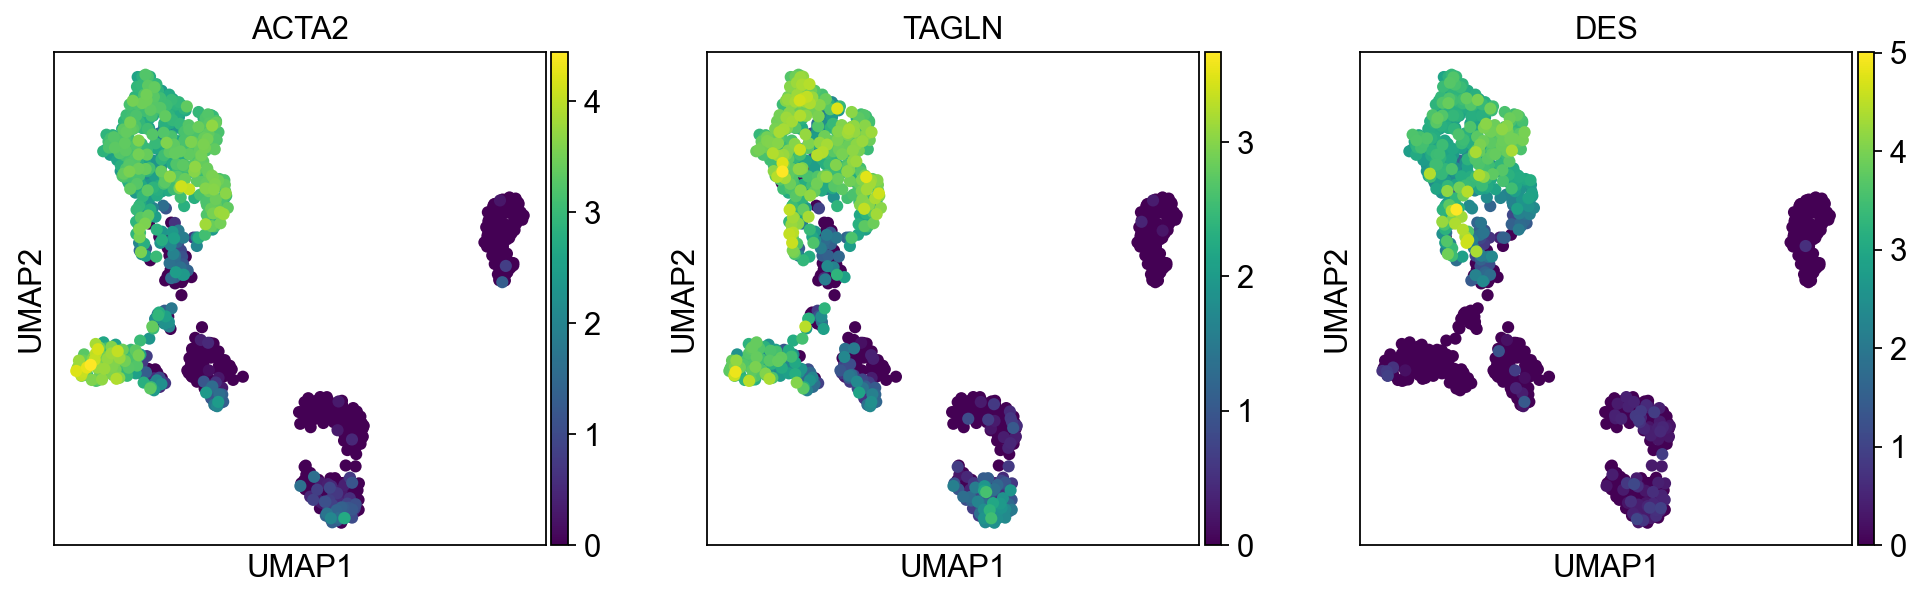

Glia


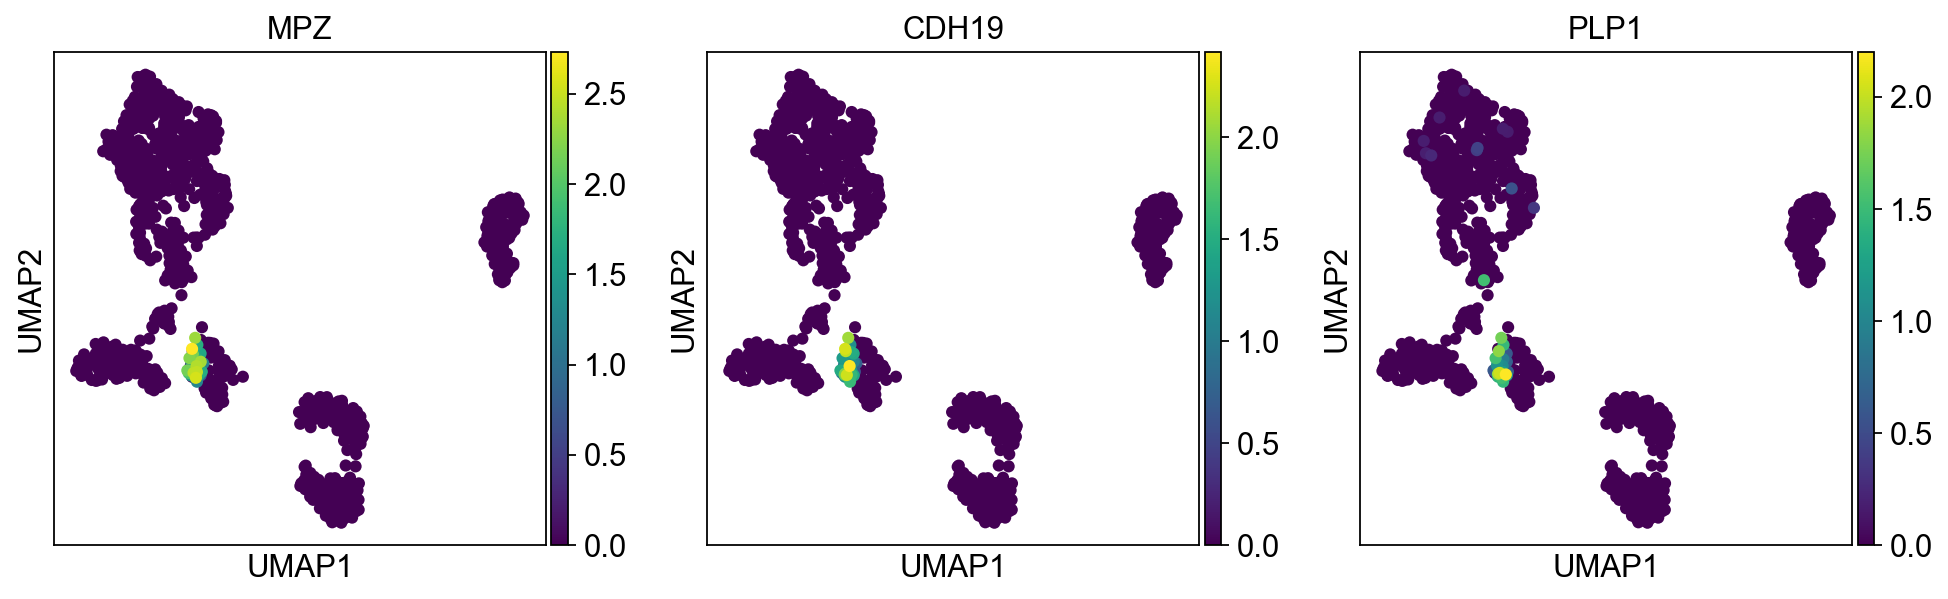

Mesothelium


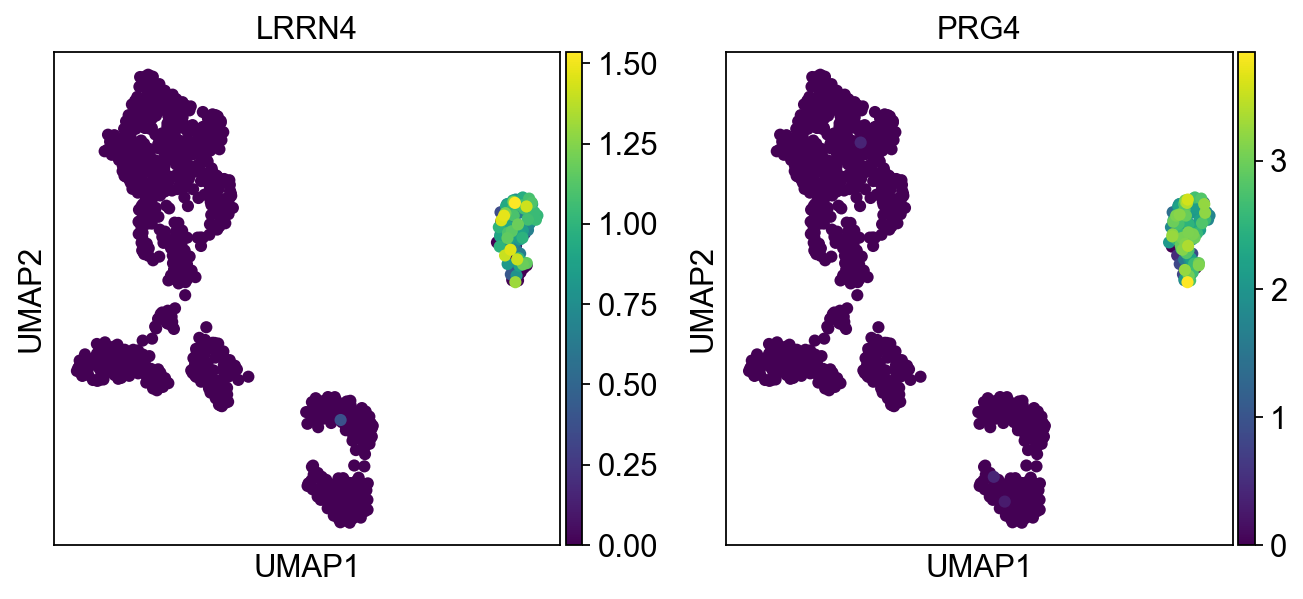

In [12]:
sc.pl.umap(stromal, color='leiden' ,ncols=5)

print('Fibroblasts')
sc.pl.umap(stromal, color=Fibroblasts+Fibroblast_types ,ncols=5)
print('Pericytes')
sc.pl.umap(stromal, color=Pericytes ,ncols=5)
print('Smcs and myofibroblast')
sc.pl.umap(stromal, color=Smcs_and_myofibroblast ,ncols=5)
print('Glia')
sc.pl.umap(stromal, color=Glia ,ncols=5)
print('Mesothelium')
sc.pl.umap(stromal, color=Mesothelium ,ncols=5)

In [13]:
stromal_types = {'0':'SMC',
'1':'Fibroblast ADAMDEC1',
'2':'SMC',
'3':'Mesothelium',
'4':'Pericyte',
'5':'Fibroblast PI16',
'6':'Glia_Mesenchymal_mix', # By the markers - a cluster of Glia cells mixed with more types.
'7':'SMC'}
 
stromal.obs['cell_type'] = stromal.obs.leiden.map(stromal_types).astype('category')
cluster_6 = stromal[stromal.obs.leiden=='6']

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cell_type']`


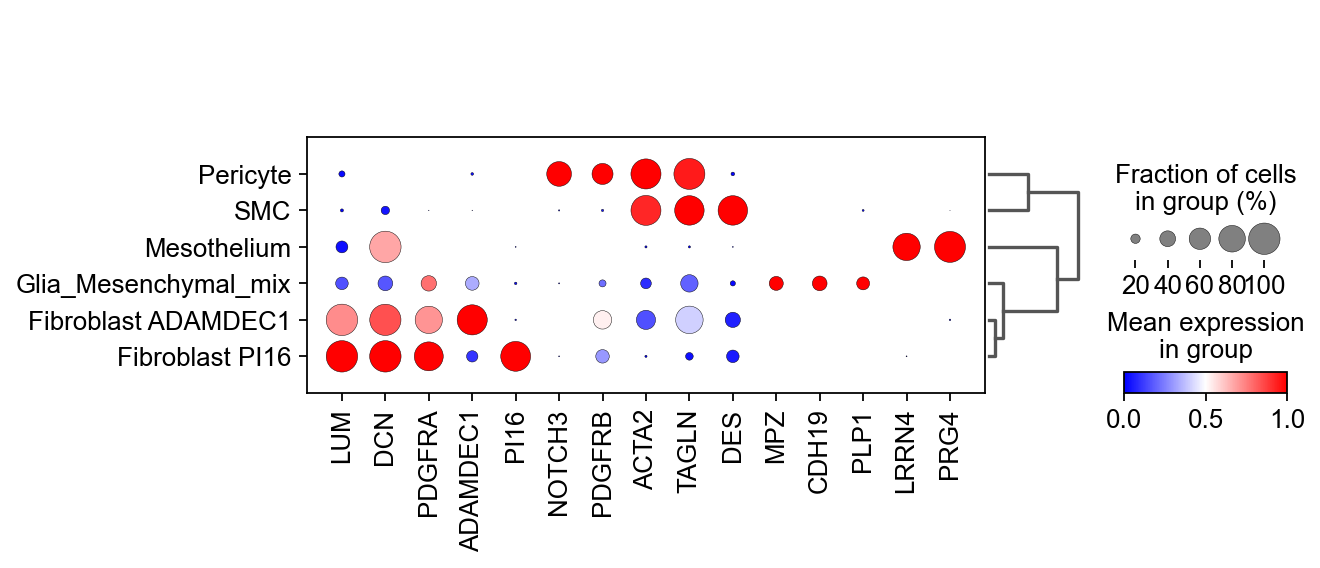

In [16]:
sc.tl.dendrogram(stromal, groupby = 'cell_type') 
sc.pl.dotplot(stromal,Fibroblasts+Fibroblast_types+Pericytes+Smcs_and_myofibroblast+Glia+Mesothelium, groupby='cell_type',dendrogram=True,cmap='bwr',standard_scale='var')

>Iterating sub clustering

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


c:\users\tzachihnb5\appdata\local\programs\python\python39\lib\site-packages\anndata\compat\_overloaded_dict.py:179: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  ovld.data[key] = neighbors


	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


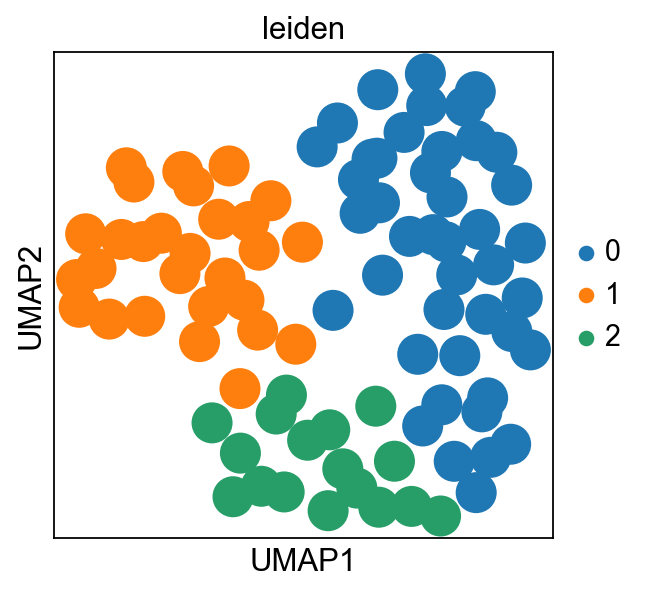

In [17]:
bbknn.bbknn(cluster_6, batch_key='Sample', neighbors_within_batch=2, metric='euclidean', n_pcs=30,trim=None)
sc.tl.umap(cluster_6)
sc.tl.leiden(cluster_6, resolution=0.4)
sc.pl.umap(cluster_6,color ='leiden')

Glia


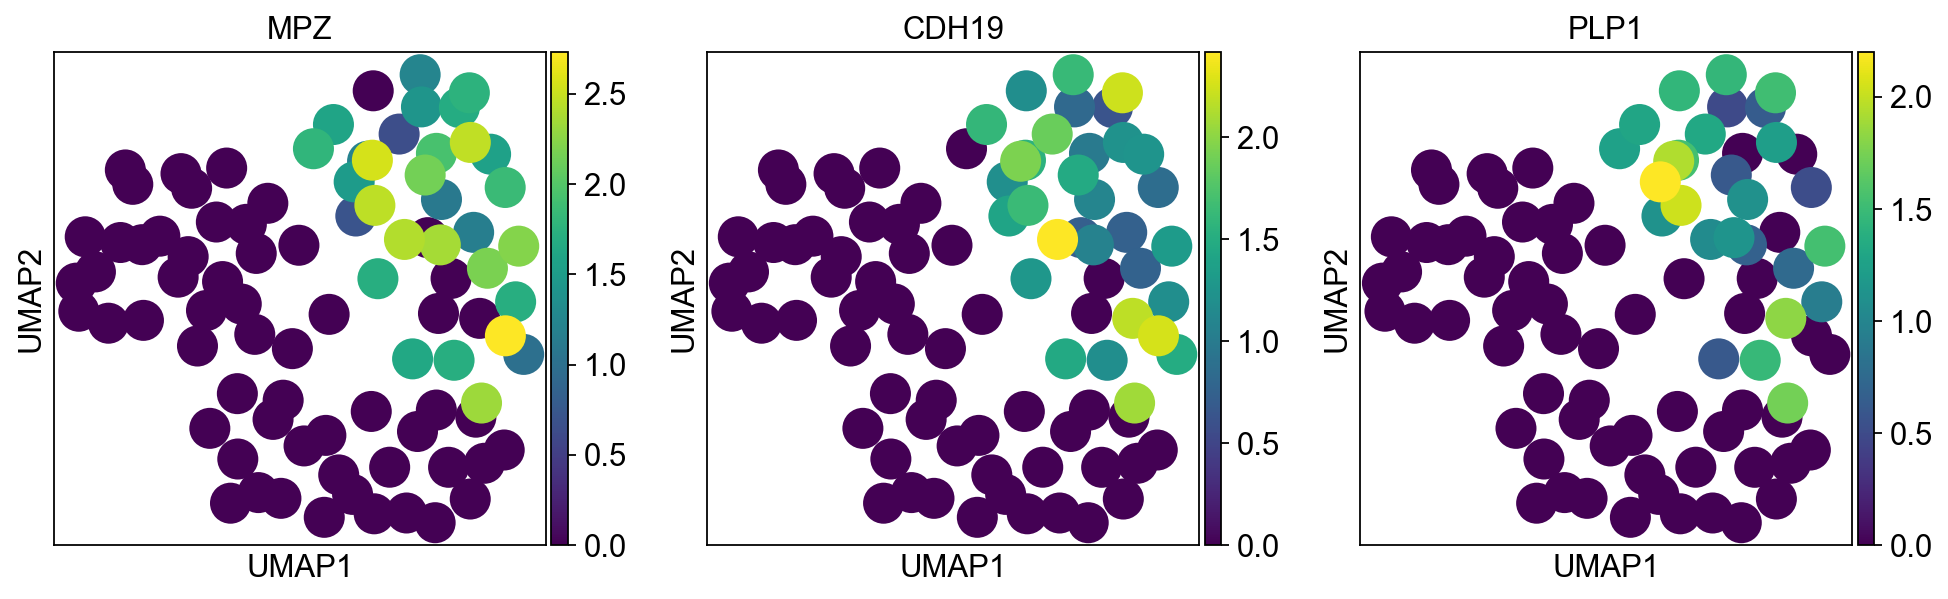

In [18]:
print('Glia')
sc.pl.umap(cluster_6, color=Glia ,ncols=5)

# Gene search tools

This function returns a list of genes that are present in adata (markers for example) from an input of a general list.

In [19]:
def find_gene(gene_list):
    gene_list_adata  = [gene for gene in gene_list if gene.upper() in list(adata.raw.var.index[adata.raw.var.index.str.startswith(gene.upper())])]
    return [i.upper() for i in gene_list_adata]

Finds genes that start with X

In [24]:
GENES= list(adata.raw.var.index[adata.raw.var.index.str.startswith('...'.upper())])
GENES